# ATCM Network Structure Investigation
We're going to work out what the structure of the ATCM network is. First, let's read the data.

In [53]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
import powerlaw
from scipy.stats import spearmanr
from itertools import combinations


lower_year_threshold = 1961  # Define your lower year threshold
upper_year_threshold = 2024  # Define your upper year threshold



# Read the ATCM dataset and initialise it into a Pandas Dataframe
def read_ATCM_dataset():
    # Define the path to the Excel file
    file_path = 'ATCMDataset.xlsx'

    # Read the Excel file into a DataFrame
    df = pd.read_excel(file_path,sheet_name='ATCMDataset')
    df['Year'] = df['Year'].astype(int)

    # Display the DataFrame
    return df

# Df is the returned pandas dataframe.
df = read_ATCM_dataset()
print(df)


                            ID  DocumentID Type  Year  \
0          ATCM45_ip001_e.docx           0   ip  2023   
1          ATCM45_ip002_e.docx           1   ip  2023   
2     ATCM45_ip003_rev1_e.docx           2   ip  2023   
3          ATCM45_ip004_e.docx           3   ip  2023   
4          ATCM45_ip005_e.docx           4   ip  2023   
...                        ...         ...  ...   ...   
6308        ATCM1_wp025_e.docx        5237   wp  1961   
6309        ATCM1_wp029_e.docx        5238   wp  1961   
6310        ATCM1_wp031_e.docx        5239   wp  1961   
6311        ATCM1_wp033_e.docx        5240   wp  1961   
6312        ATCM1_wp034_e.docx        5241   wp  1961   

                                                  Title    Submitted By  \
0     Report by the CEP Observer to the XXXVII SCAR ...          France   
1     Report by the CCAMLR Observer to the Forty Fif...          CCAMLR   
2     Report by the United Kingdom as Depositary Gov...  United Kingdom   
3     Report of

# Initialise the Network- Step 1
Initialise the node names of the various countries. <br>


26
['Norway', 'Belgium', 'Russian Federation', 'United States', 'Argentina', 'France', 'Spain', 'South Africa', 'India', 'Uruguay', 'Poland', 'SCAR', 'Korea (ROK)', 'Italy', 'Australia', 'China', 'Ukraine', 'Germany', 'Chile', 'New Zealand', 'Sweden', 'COMNAP', 'Brazil', 'United Kingdom', 'Japan', 'IAATO']
26


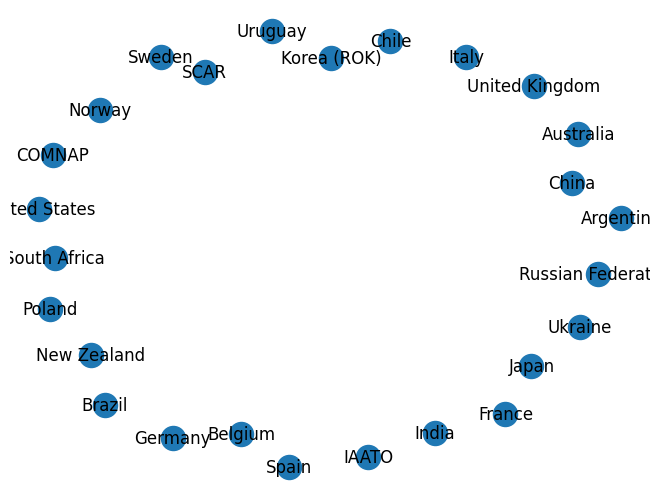

In [54]:
consultative_parties = [ 'SCAR','IAATO','COMNAP', 'United States', 'Ukraine', 'Belgium', 'New Zealand', 'Uruguay', 'Spain', 'Russian Federation', 'Italy', 'India', 'United Kingdom', 'Brazil', 'Poland', 'Japan', 'Argentina', 'China', 'Norway', 'South Africa', 'Chile', 'Sweden', 'Australia', 'Germany', 'France', 'Korea (ROK)']
print(len(consultative_parties))
def get_nodes(df):
    nodes=set()
    for row in df['Submitted By']:
        countries = [item.strip() for item in row.split(',')]
        countries=list(countries)
        countries=set(countries)
        nodes.update(countries)
    nodes=list(nodes)
        
    return nodes

# Filter the dataframe with only the WPs/IPs from lower_year_threshold to upper_year_threshold


filtered_df = df[(df['Year'] <= upper_year_threshold) & (df['Year'] >= lower_year_threshold)]

nodes=get_nodes(filtered_df)

nodes= list(set(nodes).intersection(set(consultative_parties)))
print(nodes)
print(len(nodes))


# Initialize the network in networkx
ATCM_network = nx.Graph()

# Add nodes to the graph
ATCM_network.add_nodes_from(nodes)
#ATCM_network.add_nodes_from(consultative_parties)

# Draw the network
nx.draw(ATCM_network, with_labels=True)
plt.show()
    

# Initialise the Network- Step 2
Create the graph with an edge between nodes $a$ and $b$ if they share at least one working paper. <br>
The weight of this edge is given by the number of working papers that $a$ and $b$ have collaborated on in the dataset. <br>

301
26


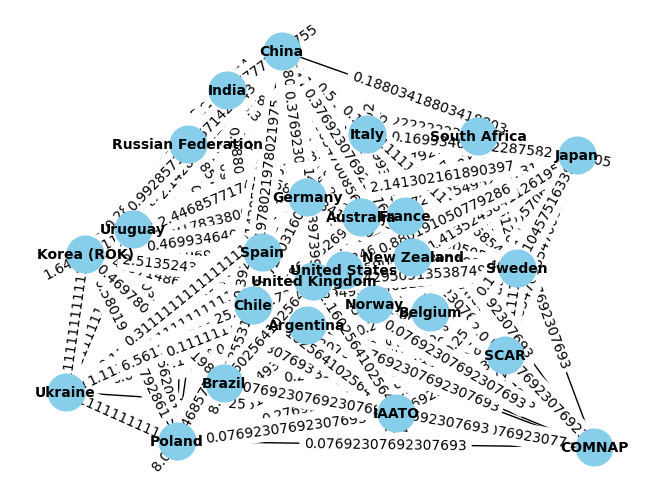

In [55]:
def add_edges(df, ATCM_network):
    """
    Modify the edge weights based on the new definition:
    
    For each paper p, for each pair of distinct authors (i, j),
    add a contribution of 1/(n_p - 1) to the weight w_ij, where
    n_p is the number of authors on paper p.
    """
    for idx, row in df.iterrows():
        # Parse the authors from the "Submitted By" field
        authors = [author.strip() for author in row['Submitted By'].split(',')]
        # Only consider authors that are nodes in the network
        authors = [a for a in authors if a in ATCM_network.nodes]
        n_p = len(authors)
        
        # If there's only one author, no edge is formed.
        if n_p > 1:
            contribution = 1 / (n_p - 1)
            # Loop through all unique pairs of authors
            for i in range(n_p):
                for j in range(i + 1, n_p):
                    a_i = authors[i]
                    a_j = authors[j]
                    # If the edge already exists, increment its weight; otherwise, add a new edge.
                    if ATCM_network.has_edge(a_i, a_j):
                        ATCM_network[a_i][a_j]['weight'] += contribution
                    else:
                        ATCM_network.add_edge(a_i, a_j, weight=contribution)


add_edges(filtered_df,ATCM_network)
print(len(ATCM_network.edges))
print(len(ATCM_network.nodes))

# Visualize the network
pos = nx.spring_layout(ATCM_network)  # Positions for all nodes with specified spacing
nx.draw(ATCM_network, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold')

# Draw edge labels
edge_labels = nx.get_edge_attributes(ATCM_network, 'weight')
nx.draw_networkx_edge_labels(ATCM_network, pos, edge_labels=edge_labels)

plt.show()

# Check Degree Distribution of the network
Graph the degree distribution in Matplotlib and see what it looks like. 

Norway 23
Belgium 25
Russian Federation 23
United States 25
Argentina 24
France 24
Spain 24
South Africa 23
India 25
Uruguay 22
Poland 24
SCAR 23
Korea (ROK) 25
Italy 24
Australia 25
China 19
Ukraine 20
Germany 24
Chile 25
New Zealand 24
Sweden 24
COMNAP 14
Brazil 22
United Kingdom 25
Japan 23
IAATO 23
DEGREE SEQUENCE:  [23, 25, 23, 25, 24, 24, 24, 23, 25, 22, 24, 23, 25, 24, 25, 19, 20, 24, 25, 24, 24, 14, 22, 25, 23, 23]
Degree Distribution Power Law Fit Coefficients (a, b): [ 1.94345331e-13 -8.69233078e+00]


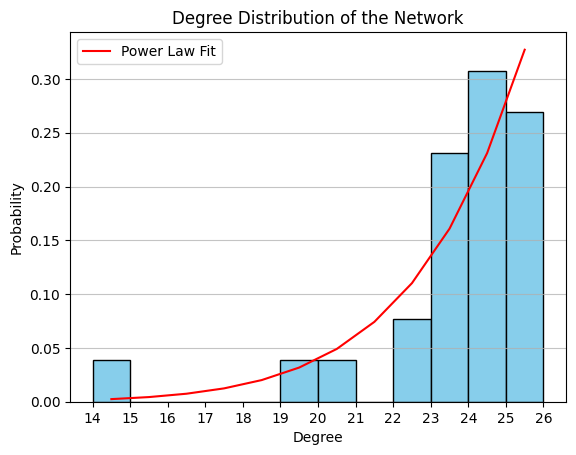

WEIGHT SEQUENCE:  [0.058823529411764705, 0.058823529411764705, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.1, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.13574660633484165, 0.13574660633484165, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.16993464052287582, 0.16993464052287582, 0.16993464052287582, 0.16993464052287582, 0.16993464052287582, 0

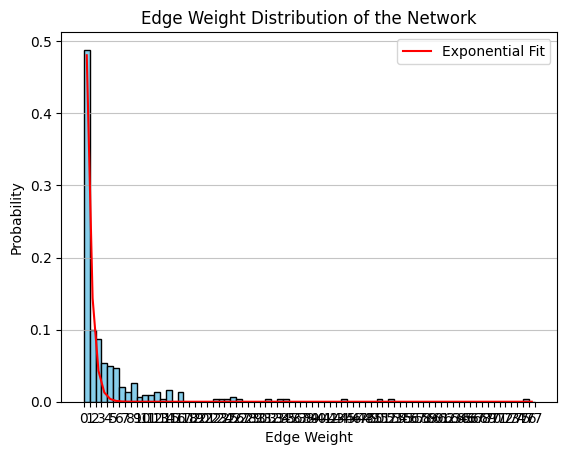

STRENGTHS
[12.999999999999995, 18.999999999999996, 22.999999999999993, 24.0, 30.99999999999999, 31.999999999999993, 33.000000000000036, 35.00000000000001, 36.00000000000001, 41.000000000000014, 44.00000000000002, 48.000000000000014, 50.000000000000014, 53.000000000000014, 84.00000000000001, 86.00000000000001, 93.99999999999999, 109.99999999999999, 115.00000000000001, 169.0, 170.0, 170.00000000000003, 185.99999999999997, 207.0, 267.0, 365.99999999999994]


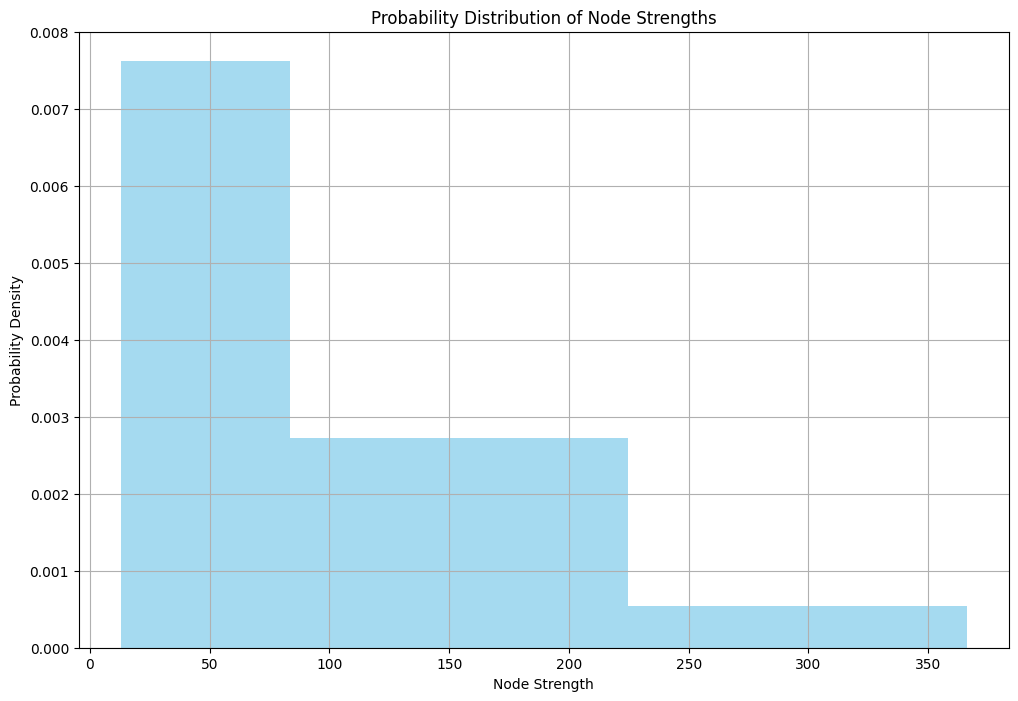

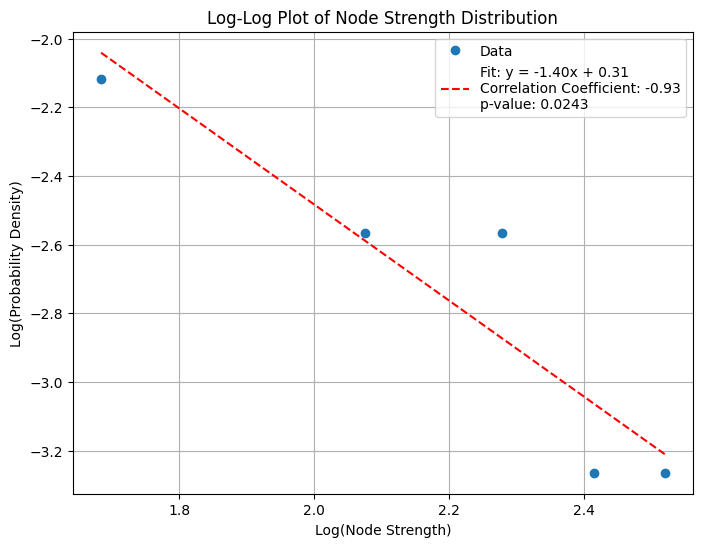

Correlation Coefficient: -0.93
p-value: 0.0243


In [56]:
# Plot a histogram of the degree.
def plot_degree_distribution(ATCM_network):
    # Define power-law function
    def power_law(x, a, b):
        return a * x**(-b)
    
    # Plot the degree distribution as a probability distribution
    degrees = [ATCM_network.degree(node) for node in ATCM_network.nodes()]
    for i in ATCM_network.nodes():
        print(i, ATCM_network.degree(i))
    print("DEGREE SEQUENCE: ", degrees)
    
    # Since degrees are integers, using range() is fine here.
    plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2),
             density=True, color='skyblue', edgecolor='black')
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.title('Degree Distribution of the Network')
    plt.xticks(range(min(degrees), max(degrees) + 2))
    plt.grid(axis='y', alpha=0.75)

    # Regression model on the power law.
    bin_centers = np.array(range(min(degrees), max(degrees) + 1)) + 0.5
    hist, bin_edges = np.histogram(degrees, bins=range(min(degrees), max(degrees) + 2), density=True)
    popt, _ = curve_fit(power_law, bin_centers, hist)

    print("Degree Distribution Power Law Fit Coefficients (a, b):", popt)
    plt.plot(bin_centers, power_law(bin_centers, *popt), 'r-', label='Power Law Fit')
    plt.legend()
    plt.show()


def plot_weight_distribution(ATCM_network):
    # Define an exponential function for the fit.
    def exponential(x, a, b):
        return a * np.exp(-b * x)

    # Calculate edge weight distribution
    edge_weights = [ATCM_network[edge[0]][edge[1]]['weight'] for edge in ATCM_network.edges()]
    edge_weights.sort()
    print("WEIGHT SEQUENCE: ", edge_weights)
    
    # Convert min and max edge weights to integers for binning.
    min_weight = int(np.floor(min(edge_weights)))
    max_weight = int(np.ceil(max(edge_weights)))
    
    # Use np.arange to define bin edges since edge_weights are floats.
    bins = np.arange(min_weight, max_weight + 2, 1)
    
    # Plot the edge weight distribution using the new bins.
    plt.hist(edge_weights, bins=bins, density=True, color='skyblue', edgecolor='black')
    plt.xlabel('Edge Weight')
    plt.ylabel('Probability')
    plt.title('Edge Weight Distribution of the Network')
    plt.xticks(bins)
    plt.grid(axis='y', alpha=0.75)

    # Calculate histogram for curve fitting.
    bin_centers = np.array(np.arange(min_weight, max_weight + 1, 1)) + 0.5
    hist, bin_edges = np.histogram(edge_weights, bins=bins, density=True)
    popt, _ = curve_fit(exponential, bin_centers, hist)
    print("Weight Distribution Exponential Fit Coefficients (a, b):", popt)
    plt.plot(bin_centers, exponential(bin_centers, *popt), 'r-', label='Exponential Fit')
    plt.legend()
    plt.show()


def plot_node_strength_distribution(ATCM_network):
    # Calculate node strengths (sum of weights of all connections for each node)
    node_strengths = {node: sum(data['weight'] for _, _, data in ATCM_network.edges(node, data=True))
                      for node in ATCM_network.nodes}
    
    # Extract strengths and plot the histogram
    strengths = list(node_strengths.values())
    print("STRENGTHS")
    strengths.sort()
    print(strengths)
    
    plt.figure(figsize=(12, 8))
    plt.hist(strengths, bins=5, density=True, alpha=0.75, color='skyblue')
    plt.xlabel('Node Strength')
    plt.ylabel('Probability Density')
    plt.title('Probability Distribution of Node Strengths')
    plt.grid(True)
    plt.show()


def plot_log_log_strength_distribution(ATCM_network):
    # Calculate node strengths
    node_strengths = {node: sum(data['weight'] for _, _, data in ATCM_network.edges(node, data=True))
                      for node in ATCM_network.nodes}

    # Remove nodes with zero strength and calculate the log-log data
    filtered_strengths = [strength for strength in node_strengths.values() if strength > 0]
    hist, bin_edges = np.histogram(filtered_strengths, bins=5, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Filter out zero values in the histogram
    non_zero_indices = hist > 0
    hist = hist[non_zero_indices]
    bin_centers = bin_centers[non_zero_indices]

    # Calculate the logarithms
    log_bin_centers = np.log10(bin_centers)
    log_hist = np.log10(hist)

    # Fit a line to the log-log data using linear regression
    slope, intercept, r_value, p_value, std_err = linregress(log_bin_centers, log_hist)

    # Create the log-log plot
    plt.figure(figsize=(8, 6))
    plt.plot(log_bin_centers, log_hist, marker='o', linestyle='none', label='Data')
    plt.xlabel('Log(Node Strength)')
    plt.ylabel('Log(Probability Density)')
    plt.title('Log-Log Plot of Node Strength Distribution')

    # Plot the fitted line
    plt.plot(log_bin_centers, slope * log_bin_centers + intercept, color='red', linestyle='--',
             label=f'Fit: y = {slope:.2f}x + {intercept:.2f}\nCorrelation Coefficient: {r_value:.2f}\n'
                   f'p-value: {p_value:.4f}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the correlation coefficient and p-value
    print(f"Correlation Coefficient: {r_value:.2f}")
    print(f"p-value: {p_value:.4f}")
plot_degree_distribution(ATCM_network)
plot_weight_distribution(ATCM_network)
plot_node_strength_distribution(ATCM_network)
plot_log_log_strength_distribution(ATCM_network)



0.9409495548961424
0.9443148372095741


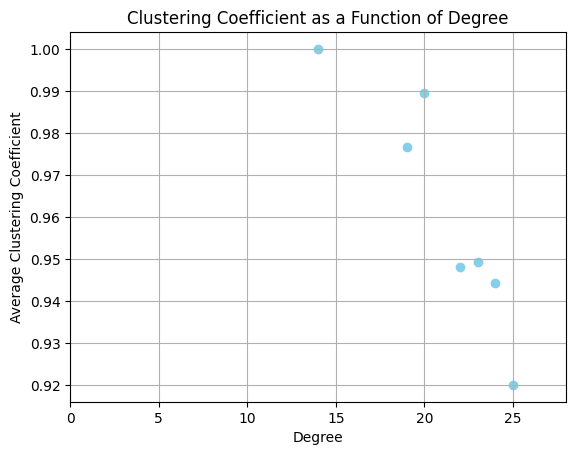

1.073846153846154
1.0018007771775186
-2.220446049250313e-16


In [57]:
# Clustering coefficient.
# Global clustering
print(nx.transitivity(ATCM_network))
# Average node clustering
print(nx.average_clustering(ATCM_network))

# Graph node clustering as a function of degree
def plot_clustering_vs_degree(G):
    degrees = dict(G.degree())
    clustering_coeffs = nx.clustering(G)

    degree_clustering = {}
    for node, degree in degrees.items():
        if degree not in degree_clustering:
            degree_clustering[degree] = []
        degree_clustering[degree].append(clustering_coeffs[node])

    avg_clustering = {degree: np.mean(clustering_coeffs) for degree, clustering_coeffs in degree_clustering.items()}
    
    degrees = list(avg_clustering.keys())
    clustering_values = list(avg_clustering.values())

    plt.scatter(degrees, clustering_values, color='skyblue')
    plt.xlabel('Degree')
    plt.ylabel('Average Clustering Coefficient')
    plt.xlim((0,28))
    plt.title('Clustering Coefficient as a Function of Degree')
    plt.grid(True)
    plt.show()

plot_clustering_vs_degree(ATCM_network)

# If we remove the disconnected bits and take the largest connected component, then we can run the small world measures.
largest_cc = max(nx.connected_components(ATCM_network), key=len)
sub = ATCM_network.subgraph(largest_cc).copy()

print(nx.average_shortest_path_length(sub))

print(nx.sigma(sub))
print(nx.omega(sub))

# Rank Correlation Analysis of Various timescales in the ATCM

Find the spearman rho (rank correlation) for the strength rankings.

In [58]:

def get_strength_rankings(t_lower, t_upper, df):
    consultative_parties = ['SCAR', 'IAATO', 'COMNAP', 'United States', 'Ukraine', 'Belgium', 'New Zealand', 
                            'Uruguay', 'Spain', 'Russian Federation', 'Italy', 'India', 'United Kingdom', 
                            'Brazil', 'Poland', 'Japan', 'Argentina', 'China', 'Norway', 'South Africa', 
                            'Chile', 'Sweden', 'Australia', 'Germany', 'France', 'Korea (ROK)']
    
    # Filter the dataframe for the specified time period
    filtered_df = df[(df['Year'] <= t_upper) & (df['Year'] >= t_lower)]
    
    # Get nodes (countries) involved in the given time frame
    nodes = get_nodes(filtered_df)
    
    # Retain only consultative parties
    nodes = list(set(nodes).intersection(set(consultative_parties)))
    
    # Initialize the network
    ATCM_network = nx.Graph()
    
    # Add nodes and edges to the network
    ATCM_network.add_nodes_from(nodes)
    add_edges(filtered_df, ATCM_network)
    
    # Calculate node strengths
    node_strengths = {node: sum(data['weight'] for _, _, data in ATCM_network.edges(node, data=True)) for node in ATCM_network.nodes}
    
    # Sort the nodes alphabetically
    sorted_node_strengths = sorted(node_strengths.items(), key=lambda item: item[0])
    
    return sorted_node_strengths



def calculate_spearman_rho(rankings_t1, rankings_t2):
    # Extract the countries and their strengths from both rankings
    countries_t1 = {country: strength for country, strength in rankings_t1}
    countries_t2 = {country: strength for country, strength in rankings_t2}
    
    # Ensure both rankings have the same countries (intersection)
    common_countries = set(countries_t1.keys()).intersection(set(countries_t2.keys()))
    
    # Sort the common countries alphabetically
    sorted_countries = sorted(common_countries)
    
    # Extract the strengths for the common countries
    strengths_t1 = [countries_t1[country] for country in sorted_countries]
    strengths_t2 = [countries_t2[country] for country in sorted_countries]
    
    # Calculate Spearman's rank correlation coefficient and p-value
    rho, p_value = spearmanr(strengths_t1, strengths_t2)
    
    return rho, p_value


periods=[1980,1990,2000,2010,2023]



def is_subset_period(t1_lower, t1_upper, t2_lower, t2_upper):
    """
    Returns True if the period (t1_lower, t1_upper) is a subset of 
    (t2_lower, t2_upper) or vice versa.
    """
    return (t1_lower >= t2_lower and t1_upper <= t2_upper) or \
           (t2_lower >= t1_lower and t2_upper <= t1_upper)

def average_spearman_rho_with_test(periods, df):
    spearman_rhos = []
    p_values = []
    
    # Generate all combinations for t1 and t2 pairs
    count=0
    for t1_lower, t1_upper in combinations(periods, 2):
        if t1_lower <= t1_upper:
            rankings_t1 = get_strength_rankings(t1_lower, t1_upper, df)
            for t2_lower, t2_upper in combinations(periods, 2):
                # Ensure periods are valid, distinct, and not subsets of one another
                if (t2_lower <= t2_upper and 
                    (t1_lower, t1_upper) != (t2_lower, t2_upper) and 
                    not is_subset_period(t1_lower, t1_upper, t2_lower, t2_upper)):
                    
                    rankings_t2 = get_strength_rankings(t2_lower, t2_upper, df)
                    count+=1
                    # Calculate the Spearman rank correlation coefficient and p-value
                    rho, p_value = calculate_spearman_rho(rankings_t1, rankings_t2)
                    spearman_rhos.append(rho)
                    p_values.append(p_value)

                    print((t1_lower,t1_upper), (t2_lower,t2_upper),rho,p_value)
        
    
    # Calculate the average Spearman rank correlation coefficient and p-value
    average_rho = sum(spearman_rhos) / len(spearman_rhos) if spearman_rhos else 0
    average_p_value = sum(p_values) / len(p_values) if p_values else 1
    
    return average_rho, average_p_value

average_rho, average_p_value = average_spearman_rho_with_test(periods, df)
print(f"Average Spearman Rank Correlation Coefficient: {average_rho:.2f}")
print(f"Average p-value: {average_p_value:.4f}")
    
    

(1980, 1990) (1990, 2000) 0.7498783651359131 5.8655382404270176e-05
(1980, 1990) (1990, 2010) 0.8346677566396257 1.3658232939084435e-06
(1980, 1990) (1990, 2023) 0.8394612397690675 1.0393468939052399e-06
(1980, 1990) (2000, 2010) 0.7516324185310835 5.5109063325107857e-05
(1980, 1990) (2000, 2023) 0.7688191433002441 2.9089108671643335e-05
(1980, 1990) (2010, 2023) 0.7727723329163332 2.492254697000186e-05
(1980, 2000) (1990, 2010) 0.7991446712394543 9.796250414209798e-07
(1980, 2000) (1990, 2023) 0.6374105589758231 0.0004612374162212569
(1980, 2000) (2000, 2010) 0.5718955156643492 0.00227024067596643
(1980, 2000) (2000, 2023) 0.5115777516903995 0.00755585245473616
(1980, 2000) (2010, 2023) 0.5128620123888726 0.007381104886423255
(1980, 2010) (1990, 2023) 0.9162107238956173 5.1257119360510356e-11
(1980, 2010) (2000, 2023) 0.8564830653438248 2.3759594327209415e-08
(1980, 2010) (2010, 2023) 0.8359842776617596 1.0549331753890656e-07
(1990, 2000) (1980, 1990) 0.7498783651359131 5.865538240427

# Consistent structure in ATS

Antarctic treaty is a constellation of treaties

Consistent structures --> Consistent across the systems (across the treaties) and consistent across time. Caveat: Early years of CCAMLR were one of flux. 

Worth thinking about the structure of the network. 

Co-authorship network. Reasonable metric of alignment and collaboration --> Used a lot elsewhere, co-sponsorship, politics etc...

Is this predictive of the actions. 

Can we predict which country wouldn't ratify? Which country would not have co-authored that paper. 